In [13]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau



In [6]:
def load_dataset(dataset_path):
    x_train = []
    y_train = []
    class_names = sorted(os.listdir(dataset_path))

    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(class_path, filename)
                    image = cv2.imread(image_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = np.array(image)
                    image = image / 255.0
                    if image is not None:
                        x_train.append(image)
                        y_train.append(class_index)

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    return x_train, y_train

In [3]:
def create_model(input_shape, num_classes):
    # Load the MobileNetV2 model with pre-trained weights on ImageNet
    base_model = MobileNetV2(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )
    
    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Add a dense layer with 128 neurons and ReLU activation
    x = Dense(128, activation='relu')(x)
    
    # Add a final dense layer with 4 neurons (one for each class) and softmax activation
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the new model with the modified architecture
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze the weights of the base model to avoid overfitting on small datasets
    for layer in base_model.layers:
        layer.trainable = False

    return model

In [7]:
# Dataset directory
dataset_directory = "data/MSID_US_AUG"

# Load dataset into x_train and y_train arrays
x_train, y_train = load_dataset(dataset_directory)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)


In [8]:
x_train.shape, x_test.shape

((4137, 224, 224, 3), (1035, 224, 224, 3))

In [14]:
# Configuration and model parameters
input_shape = (224, 224, 3)
num_classes = 4
batch_size = 32
epochs = 20
lr = 0.001 # default from Adam


In [15]:
# Inicializar listas para almacenar las métricas en cada iteración
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

In [16]:
# Set the number of folds
num_folds = 5

# Initialize the KFold object
kf = KFold(n_splits=num_folds)

# Perform the cross-validation
fold = 1
for train_index, val_index in kf.split(x_train):
    print("====================")
    print(f"Iteracion {fold}:")
    print("====================")

    # Get train and validation data
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    y_train_fold_one_hot = tf.keras.utils.to_categorical(y_train_fold, num_classes=4)
    y_val_fold_one_hot = tf.keras.utils.to_categorical(y_val_fold, num_classes=4)
    

    model = create_model(input_shape, num_classes)

    model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
    )

    # Set up the learning rate schedule
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, min_lr=0.00001)
    
    # Train the model using fit_generator with the learning rate schedule
    model.fit(
        x_train_fold, y_train_fold_one_hot, 
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[reduce_lr],
        validation_data=(x_val_fold, y_val_fold_one_hot),
        verbose=1)

    
    print(f"Fold {fold}:")
    print("Training data - X shape:", x_train_fold.shape)
    print("Training data - y shape:", y_train_fold_one_hot.shape)
    print("Validation data - X shape:", x_val_fold.shape)
    print("Validation data - y shape:", y_val_fold_one_hot.shape)    
    print("Validation data - Start index:", val_index[0])
    print("Validation data - End index:", val_index[-1])
    print()

    # Predict on the validation data
    y_pred = model.predict(x_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    # Calculate the metrics
    precision = precision_score(y_test, y_pred_labels, average='macro')
    recall = recall_score(y_test, y_pred_labels, average='macro')
    f1 = f1_score(y_test, y_pred_labels, average='macro')
    accuracy = accuracy_score(y_test, y_pred_labels)

    # Append the metrics to the lists
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)
    
    # Print the metrics
    print(f"Metrics for Fold {fold}:")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)
    print()

    model.save(f"models/model_fold{fold}.h5")
    
    fold += 1

# Calculate the average metrics
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)
avg_accuracy = np.mean(accuracy_scores)

# Print the average metrics
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1 Score:", avg_f1)
print("Average Accuracy:", avg_accuracy)

Iteracion 1:
Epoch 1/20
104/104 [==============================] - 26s 241ms/step - loss: 0.5247 - accuracy: 0.8096 - val_loss: 0.2432 - val_accuracy: 0.9227 - lr: 0.0010
Epoch 2/20
104/104 [==============================] - 23s 221ms/step - loss: 0.1823 - accuracy: 0.9408 - val_loss: 0.1736 - val_accuracy: 0.9432 - lr: 0.0010
Epoch 3/20
104/104 [==============================] - 23s 218ms/step - loss: 0.0902 - accuracy: 0.9719 - val_loss: 0.1565 - val_accuracy: 0.9529 - lr: 0.0010
Epoch 4/20
104/104 [==============================] - 24s 229ms/step - loss: 0.0455 - accuracy: 0.9918 - val_loss: 0.1109 - val_accuracy: 0.9614 - lr: 0.0010
Epoch 5/20
104/104 [==============================] - 24s 227ms/step - loss: 0.0230 - accuracy: 0.9988 - val_loss: 0.1008 - val_accuracy: 0.9722 - lr: 0.0010
Epoch 6/20
104/104 [==============================] - 24s 228ms/step - loss: 0.0145 - accuracy: 0.9991 - val_loss: 0.0936 - val_accuracy: 0.9746 - lr: 0.0010
Epoch 7/20
104/104 [===================

/Users/felix/anaconda3/envs/md/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/felix/anaconda3/envs/md/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


33/33 [==============================] - 6s 165ms/step


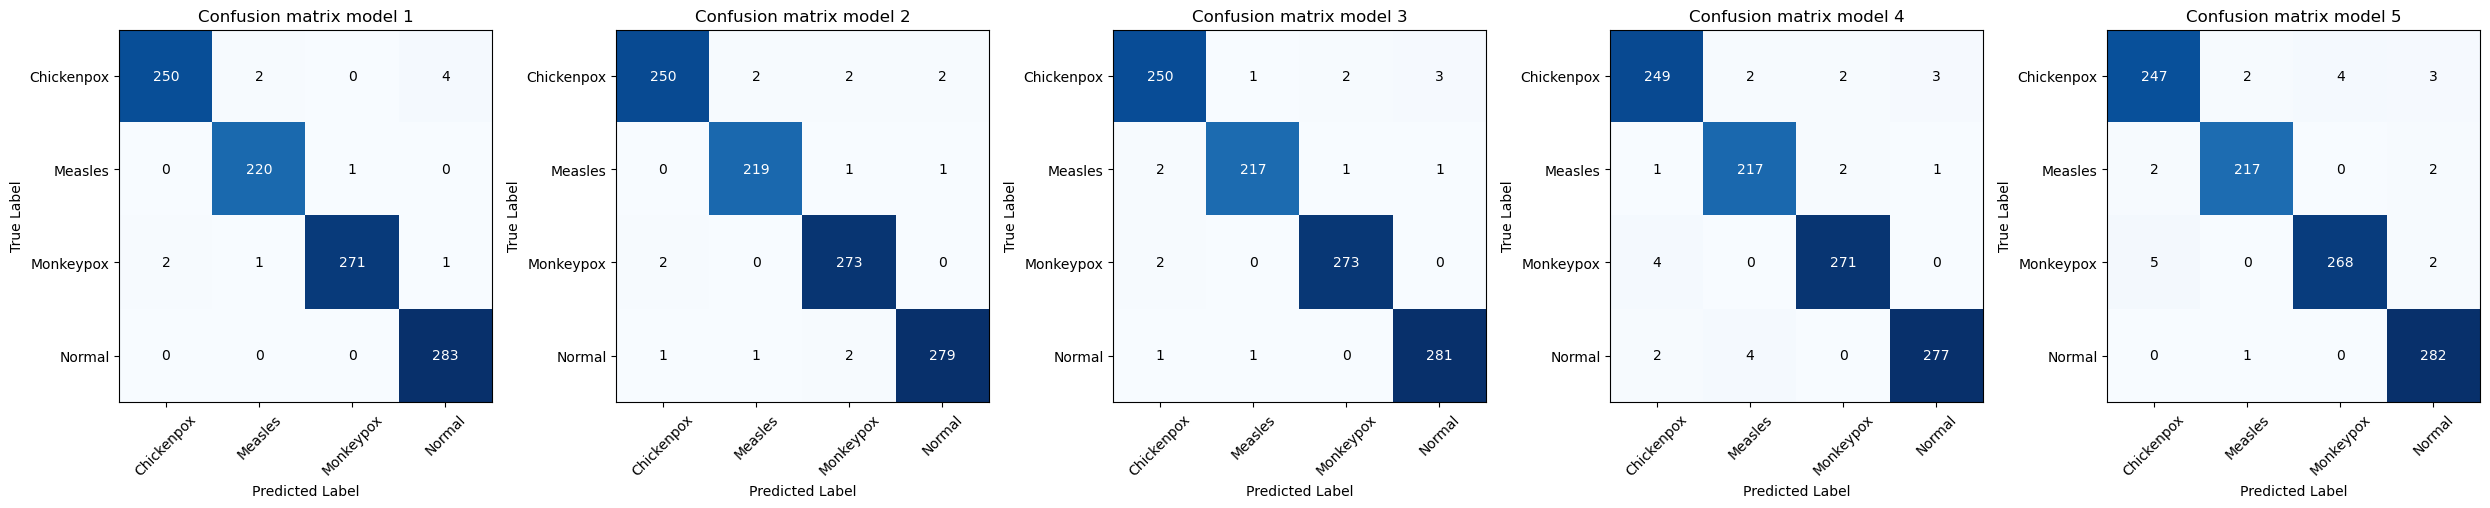

In [20]:
y_pred_labels_list = []

for i in range(5):

    #load model
    model_path = f'models/model_fold{i + 1}.h5'
    model = load_model(model_path)
    
    
    y_pred = model.predict(x_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_pred_labels_list.append(y_pred_labels)

# Plotear las matrices de confusión
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
for i, ax in enumerate(axes):
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred_labels_list[i])
    
    # Plotear la matriz de confusión
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(f'Confusion matrix model {i+1}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    tick_marks = np.arange(len(class_labels))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_labels, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_labels)
    
    # Agregar los valores de la matriz en cada celda
    thresh = cm.max() / 2.0
    for j, k in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(k, j, format(cm[j, k], 'd'), ha="center", va="center",
                 color="white" if cm[j, k] > thresh else "black")

plt.tight_layout()
plt.show()